In [1]:
#!/usr/bin/env python
# coding: utf-8

# ### Tensorflow time series forecasting applied to driving cycle data
# Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Driving cycle dataset
df_ = pd.read_csv('data/nedc.csv', names=['t (s)', 'v (km/h)'], index_col='t (s)')

# Have it repeated
df_ = pd.concat([df_, df_[1:]], ignore_index=True)
df_.index.name = 't (s)'

# Normalize the data
# Use all the data for training (no split)
df_mean = df_.mean()
df_std = df_.std()
df = (df_ - df_mean) / df_std


# Class for data windowing
class WindowGenerator():
    # 1. Indexes and offsets
    def __init__(self, input_width, label_width, shift,
                 df=df, label_columns=None):
        # Store the raw data.
        self.df = df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

        # Store example batch of tf.data.Dataset
        self._example = None

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    # 2. Split into inputs/labels
    def split_window(self, features):
        # [batch_size, window_size, features]
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    # 3. Plot
    def plot(self, model=None, plot_col='v (km/h)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col] # Here we have only one input column.
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()
                  
        plt.xlabel('Time [s]')

    # 4. Create tf.data.Dataset
    # Convert pandas.DataFrame to tensorflow.data.Dataset
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.df)

    @property
    def example(self):
        result = next(iter(self.train))
#         result = getattr(self, '_example')
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


MAX_EPOCHS = 100


def compile_and_fit(model, window, patience=2):
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                       patience=patience,
#                                                       mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.train)
#                         callbacks=[early_stopping])
    
    return history


# Multi-step prediction models

OUT_STEPS = 30
IN_STEPS = 60
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# RNN
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])])

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89]
Label column name(s): None> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89]
Label column name(s): None> and wil

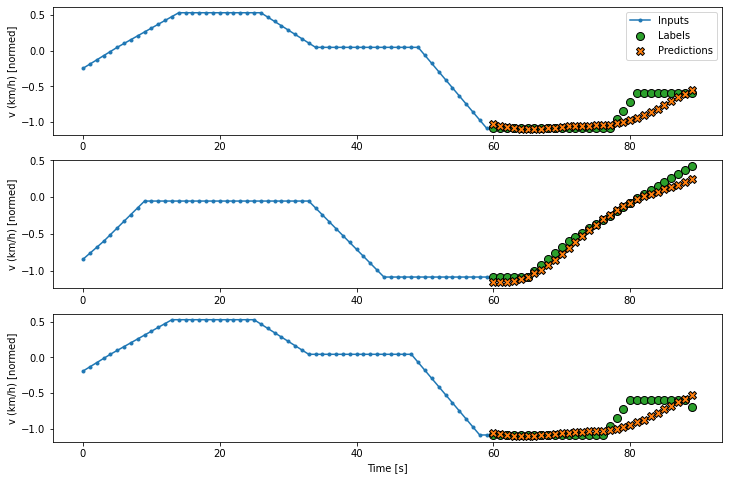

In [2]:
history = compile_and_fit(multi_lstm_model, multi_window)

multi_performance = {'LSTM': multi_lstm_model.evaluate(multi_window.train)}

multi_window.plot(multi_lstm_model)
plt.show()

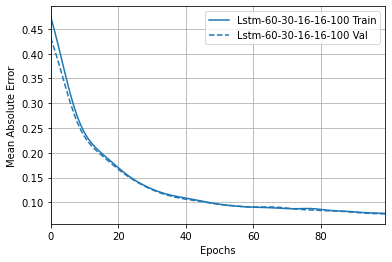

In [5]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

histories = {}
histories['LSTM-60-30-16-16-100'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(histories)

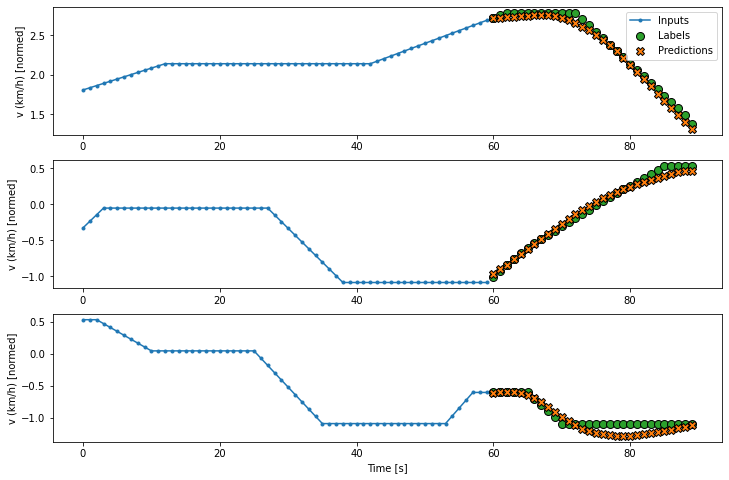

In [7]:
multi_window.plot(multi_lstm_model)

In [8]:
multi_lstm_model.save("60-30-16-16-100")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 60-30-16-16-100\assets


In [337]:
new_data = np.array(df, dtype=np.float32)
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=new_data,
    targets=None,
    sequence_length=IN_STEPS,
    sequence_stride=1,
    shuffle=False,
    batch_size=32)

predictions = multi_lstm_model.predict(ds)
predictions = (predictions * df_std[0]) + df_mean[0]
predictions

array([[[25.807232 ],
        [27.953924 ],
        [29.641182 ],
        ...,
        [22.762241 ],
        [20.272346 ],
        [17.569994 ]],

       [[27.640913 ],
        [29.382715 ],
        [30.656763 ],
        ...,
        [18.799568 ],
        [15.830862 ],
        [12.743029 ]],

       [[29.830505 ],
        [31.023659 ],
        [31.77119  ],
        ...,
        [15.1733055],
        [11.921131 ],
        [ 8.662056 ]],

       ...,

       [[-1.8147774],
        [-2.1009064],
        [-2.210144 ],
        ...,
        [ 4.987404 ],
        [ 4.583435 ],
        [ 4.3726044]],

       [[-1.9947891],
        [-2.057354 ],
        [-1.9317322],
        ...,
        [ 4.896612 ],
        [ 4.4781017],
        [ 4.2369175]],

       [[-1.9562111],
        [-1.8177452],
        [-1.4840431],
        ...,
        [ 4.8281307],
        [ 4.4023056],
        [ 4.134012 ]]], dtype=float32)

In [338]:
def plot_orig(i, predictions):
    new_data = np.array(df_, dtype=np.float32)
    
    input_indices = np.arange(i, i+IN_STEPS)
    label_indices = np.arange(i+IN_STEPS, i+IN_STEPS+OUT_STEPS)

    inputs = new_data[i:i+IN_STEPS, 0]
    labels = new_data[i+IN_STEPS:i+IN_STEPS+OUT_STEPS, 0]

    plt.figure(figsize=(12, 3))
    plt.plot(input_indices, inputs,
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(label_indices, labels,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    plt.scatter(label_indices, predictions[i, :, 0],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
    
    plt.legend()

    plt.xlabel('Time [s]')
    plt.ylabel('v (km/h) [normed]')

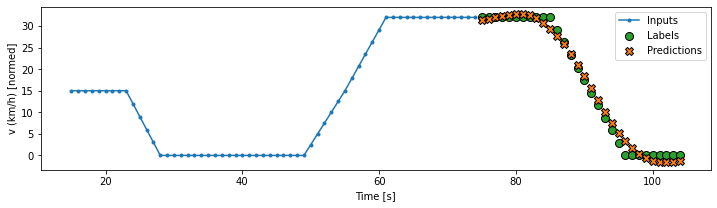

In [355]:
plot_orig(15, predictions)

In [332]:
predictions = predictions.flatten()
predictions.shape

(69960,)

In [331]:
pd.DataFrame(predictions).plot(figsize=(12.8,4.8), label='v')

ValueError: Must pass 2-d input. shape=(2332, 30, 1)

#### Prepare to export to a csv file

In [29]:
predicted_df = pd.DataFrame(predictions, columns=['v (km/h)'])
predicted_df = pd.concat([df_[:32], predicted_df], ignore_index=True)
predicted_df.index.name = 'time'
predicted_df.columns = ['v']
predicted_df

,v
time,
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
2363,0.733406
2364,1.673010
2365,2.651236


In [30]:
predicted_df = predicted_df[:2361]
predicted_df

,v
time,
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
2356,-3.099983
2357,-2.767303
2358,-2.392113


In [31]:
predicted_df = predicted_df.applymap(lambda x: 0 if x < 0 else x)
predicted_df

,v
time,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2356,0.0
2357,0.0
2358,0.0


In [32]:
# convert to (m/s)
predicted_df = predicted_df.applymap(lambda x: x * 1000 / 3600)
predicted_df

,v
time,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2356,0.0
2357,0.0
2358,0.0


In [33]:
# np.savetxt('prediction_v.csv', predictions, delimiter=',', header='time,v', comments='')
predicted_df.to_csv("prediction_v.csv")

#### Plot SoC the result

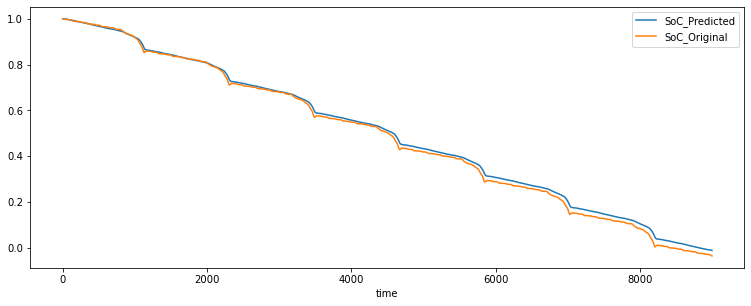

In [18]:
soc_p_df = pd.read_csv('prediction_soc.csv', index_col='time')
soc_df = pd.read_csv('soc.csv', index_col='time')

# soc_p_df.plot(figsize=(12.8,4.8), label='SoC')
# soc_df.plot(figsize=(12.8,4.8), label='SoC')

plt.rcParams["figure.figsize"] = (12.8, 4.8)
ax1 = soc_p_df.plot(y='Soc', label='SoC_Predicted')
ax2 = soc_df.plot(y='Soc', label='SoC_Original', ax=ax1)
plt.xlabel('time')
plt.show()